In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(HEIGHT, WIDTH, 3))

base_model.summary()

Using TensorFlow backend.
W0927 21:54:38.621436 13504 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 21:54:38.634467 13504 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 21:54:38.638444 13504 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0927 21:54:38.655436 13504 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [2]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = r"D:\NUS_TERM2_CA2\Train"
TEST_DIR = r"D:\NUS_TERM2_CA2\Validation"

HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

datagen2 = ImageDataGenerator(
    rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

validation_generator = datagen2.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)


Found 2424 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


In [4]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["food", "landmark", "people"]
FC_LAYERS = [128, 128]
dropout = 0.3

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

finetune_model.summary()

W0927 21:55:36.552062 13504 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [5]:
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from PIL import Image

NUM_EPOCHS = 40
BATCH_SIZE = 8
num_train_images = 2424

finetune_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

W0927 21:55:40.070021 13504 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 21:55:40.140053 13504 deprecation.py:323] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
303/303 [==============================] - 46s 151ms/step - loss: 0.5763 - acc: 0.7781

Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 2/40
303/303 [==============================] - 41s 136ms/step - loss: 0.2451 - acc: 0.9146

Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 3/40
303/303 [==============================] - 43s 142ms/step - loss: 0.1998 - acc: 0.9356

Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 4/40
303/303 [==============================] - 44s 144ms/step - loss: 0.1819 - acc: 0.94060s - loss: 0.1820 - acc: 0.940

Epoch 00004: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 5/40
303/303 [==============================] - 44s 145ms/step - loss: 0.1399 - acc: 0.9513

Epoch 00005: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 6/40
303/303 [==============================] - 44s 144ms/step - loss: 0.1360 - acc: 0.9530

Epoch 00006: saving model to ./

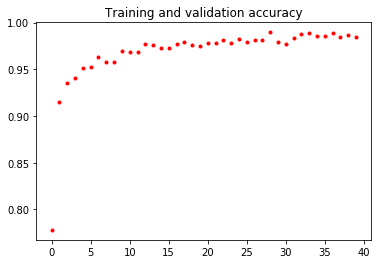

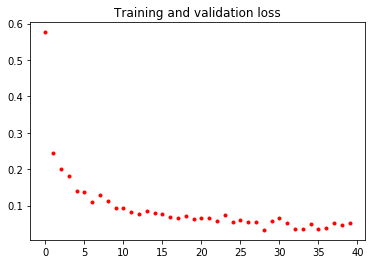

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
#     val_acc = history.history['val_acc']
    loss = history.history['loss']
#     val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
#     plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
#     plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')
    
plot_training(history)

In [7]:
TEST_DIR = r"D:\NUS_TERM2_CA2\Validation"

test_generator = datagen.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

# Todo, add test
filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = finetune_model.evaluate_generator(test_generator, workers=8, steps = nb_samples //BATCH_SIZE, verbose=1)
print('Loss is')
print(loss)
print('accuracy is')
print(acc)

Found 720 images belonging to 3 classes.
90/90 [==============================] - 14s 160ms/step
Loss is
0.047796775933368625
accuracy is
0.9833333333333333


In [ ]:
predict = finetune_model.predict_generator(test_generator,steps = nb_samples //BATCH_SIZE, verbose=1)
